# Software Notes 1 - Simple Linear Regression 

Prepared for ISyE 4031 <br>
Brandon Kang <br>
brandonkang@gatech.edu

We will be using different libraries to implement simple linear regression in Python. Make sure you install dependencies in order to run the code blocks below. If you would like a refresher on DataFrames, feel free to review this tutorial: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html ! Below I listed the libraries we will use and links for directions to install each package. <br>
1. Pandas
    - Open source library that will allow us to manipulate DataFrames for data analysis.
    - https://pandas.pydata.org/pandas-docs/stable/install.html
2. Numpy
    - Package used for scientific computing and efficient matrix calculations.
    - https://scipy.org/install.html
3. Matplotlib
    - Library used for visualizations
    - https://matplotlib.org/3.1.1/users/installing.html
4. Seaborn
    - Built on top of Matplotlib that allows us to create visually appealing visualizations quickly
    - https://seaborn.pydata.org/installing.html
5. StatsModels
    - We will use this to implement our simple linear regression model
    - https://www.statsmodels.org/0.9.0/install.html

### StatsModels vs. Sci-Kit Learn
Sci-Kit Learn is a Machine Learning library which allows us to quickly build pipelines that allows us to build classifiers/regressors and implement other supervised and unsupervised learning models. Because of its popularity, I will include the code to implement basic linear regression in later notes, but I will not go into it too in depth due to the lack of statistical outputs. Instead, we will use StatsModels to do much of the statistical analysis for linear regression. StatsModels provides us the statistical framework in order to evaluate the statistical models we will build, including the results of the hypothesis testing as well as linear regression. Although Sci-Kit Learn is powerful, it lacks some of the statistical analysis we need in order to verify our linear regression models. Instead, StatsModels will provide statistical outputs that will allow us to determine whether or not our linear regression model is feasible, and we will be dealing with relatively small datasets, so computational efficiency is not a concern as of now.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [2]:
dfGPA = pd.read_csv("gpa.csv")
dfGPA.head()

,SAT,GPA
0,1714,2.40
1,1664,2.52
2,1760,2.54
3,1685,2.74
4,1693,2.83


## Basic Exploratory Data Analysis

Before running any models on your dataset, it is always a good idea to do some basic exploratory analysis. To understand the results of your model, you first have to understand your data! What is the distribution of the data, measures of mean/std, any weird/unusual data points, etc.?

In [3]:
dfGPA.describe() #produce some quick basic statistics

,SAT,GPA
count,84.000000,84.000000
mean,1845.273810,3.330238
std,104.530661,0.271617
min,1634.000000,2.400000
25%,1772.000000,3.190000
50%,1846.000000,3.380000
75%,1934.000000,3.502500
max,2050.000000,3.810000


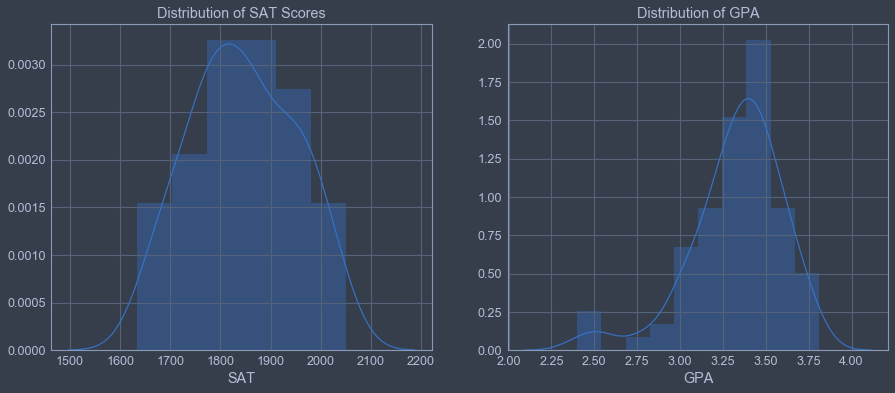

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(dfGPA["SAT"], ax=ax[0])
ax[0].title.set_text("Distribution of SAT Scores")
sns.distplot(dfGPA["GPA"], ax=ax[1])
ax[1].title.set_text("Distribution of GPA")

From our initial observations, we can identify the measures of central tendency, and the distributions of both the GPA and SAT scores look fairly normal.

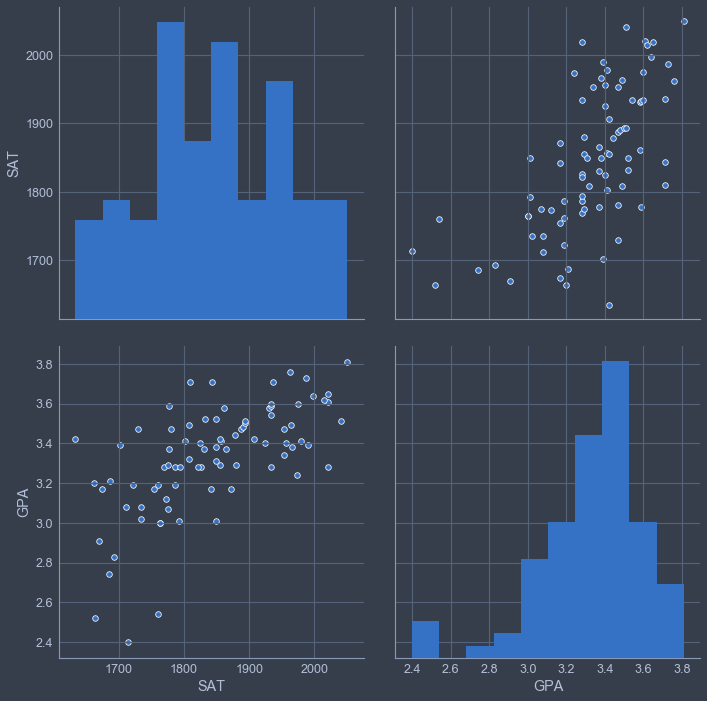

In [5]:
sns.pairplot(dfGPA, height=5)

The above visualization is called a *matrix plot*. These are extremely useful for your initial data analysis to quickly detect any relationships between the variables. As you can see, it provides plots of each variable against each other variable as well as a distribution plot of each variable. The plots, however, are identical about the diagonal. Look at the bottom left and top right scatterplots, and you can see that they are the same plot with the axes flipped. Therefore, you only need to look at one side of the diagonal. However, matrix plots are not always entirely useful. If you are dealing with datasets with a large feature space, the plot will become extremely large (by the order of $n^2$). It will become harder to visualize and draw analysis if your feature space is too large if you were to use matrix plots.

## Simple Linear Regression - Concepts

### Introduction
Let's begin with the fundamental concepts of linear regression. We are given some data, $D=\{x^{(n)}, y^{(n)}\}_{n=1}^N$. Following this notation just means that there are N data points, and each data point has some output, $y^{(n)}$, that is the true output. 

In these notes, I will refer to $x^{(n)}$ as features. Think of features as variables, and your output *may or may not* have some dependency on your features/variables. The goal of linear regression is to capture this possible dependency and find some *linear* function that can encapture this dependency between the features and output.

Of course, there may be no dependency at all, and a solution found from running linear regression may not be helpful at all. Let's first dive into how an optimum solution can be found and why this is an optimum solution.

### OLS and Loss Functions
In many classifiers and regressors, there is a fundamental concept of a "loss function." This can be easily explained through an example. Suppose you're trying to teach a dog to stay by putting your palm out. You put your palm out, and if your dog obeys, you reward him with one treat. If he doesn't he doesn't receive a treat. Let's make this ever so slightly more mathematical.
<br>
<br>

$$\begin{align}
Loss(\text{action}) = \begin{cases}
1 & \text{action } = \text{does not stay} \\
0 & \text{action } = \text{stay}
\end{cases}
\end{align}$$

<br>
<br>
From the loss function above, we penalize it by 1 everytime the dog doesn't stay when the hand is held out. It doesn't have to be 1, but for simplicity, I kept it binary. There is no loss if the dog obeys, but the loss is penalized by 1 if the dog does not obey. In reality, loss functions can be complex or very simple, and it's dependent on your data! From this it's obvious that we want to minimize the loss, so the dog will learn through time to stay that will ultimately prevent more losses. Of course, the dog doesn't know there's a loss function, but you get the gist of it! :)

The same idea can be applied to linear regression. In linear regression, our loss function is the *squared error* - aka the squared difference between the *ground truth* (the true $y$ value) and the predicted value from our regression ($\hat{y}$). Why do we use the squared error? It turns out that there are some nice statistical properties of using squared errors and the fact that it's differentiable everywhere, but the main reason is that linear regression uses some *very important* assumptions that we'll cover later that makes it the best choice. As a result, ordinary least squares produces unbiased estimates and minimizes the variance of the errors. Recall that we want to *minimize* a loss function, so our main objective is the following.

$$\begin{align}
&\min_{\beta_0,\beta_1} \sum_{i=1}^N(y_i-\hat{y}_i)^2\\
=&\min_{\beta_0,\beta_1} \sum_{i=1}^N(y_i-\hat{\beta_0}-\hat{\beta_1}x_i)^2
\end{align}
$$

You should also be able to make some conclusions off of this loss function, so let's dissect this a little more:
1. You essentially want to find some parameters, or $\beta$, that will minimize the squared errors. Remember, the error is the difference between the ground truth and predicted value.
2. The losses are always positive. If you make some mistake, then you want to incur some loss. You can't "take away" or decrease loss because you will always make some error unless your model returns a prediction that exactly matches the ground truth. In that case, no loss will be incurred. 
3. Think about the worst case scenario. OLS will penalize outliers heavily due to the squared term. (This is outside the scope of the course, but think about datasets that are corrupted with a lot of outliers. Is OLS always the best way to go then?)
4. The optimization problem has a closed form solution since the function is convex and differentiable. Differentiate with respect to each of the $\beta$'s, set equal to 0, and solve for your estimators.

## Simple Linear Regression Implementation with StatsModels

In [6]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [7]:
X = sm.add_constant(dfGPA["SAT"]) #This implementation of OLS does not add constant/intercept by default, so we must add it in
y = dfGPA["GPA"]

model = sm.OLS(y, X).fit()
model.summary()

C:\Users\brand\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GPA   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     56.05
Date:                Fri, 17 Jan 2020   Prob (F-statistic):           7.20e-11
Time:                        00:07:53   Log-Likelihood:                 12.672
No. Observations:                  84   AIC:                            -21.34
Df Residuals:                      82   BIC:                            -16.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2750      0.409      0.673      0.503      -0.538       1.088
SAT            0.0017      0.000      7.487      0.000       0.001       0.002
==============================================================================
Omnibus:                       12.839   Durbin-Watson:                   0.950
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.155
Skew:                          -0.722   Prob(JB):                     0.000310
Kurtosis:                       4.590   Cond. No.                     3.29e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**NOTE**: There are two implementations of OLS in StatsModels. You may use the one above, but note that using the model above will **NOT** allow you to run ANOVA results. In order to get ANOVA results, you have to use the ols implementation in the below code block. Therefore, it's probably best to just follow the next two blocks since you will need to produce ANOVA outputs for HW's.

In [8]:
model = ols("GPA~SAT", data=dfGPA).fit() #note that there are 2 OLS in statsmodels; I'm using this one to produce ANOVA results
model.summary() #model output

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GPA   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     56.05
Date:                Fri, 17 Jan 2020   Prob (F-statistic):           7.20e-11
Time:                        00:07:53   Log-Likelihood:                 12.672
No. Observations:                  84   AIC:                            -21.34
Df Residuals:                      82   BIC:                            -16.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2750      0.409      0.673      0.503      -0.538       1.088
SAT            0.0017      0.000      7.487      0.000       0.001       0.002
==============================================================================
Omnibus:                       12.839   Durbin-Watson:                   0.950
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.155
Skew:                          -0.722   Prob(JB):                     0.000310
Kurtosis:                       4.590   Cond. No.                     3.29e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
sm.stats.anova_lm(model) #ANOVA output

,df,sum_sq,mean_sq,F,PR(>F)
SAT,1.0,2.486122,2.486122,56.048048,7.199518e-11
Residual,82.0,3.637273,0.044357,NaN,NaN


Here, GPA is the "Regression" that you see in other outputs, and Residuals correspond to "Errors".

## Visualize Linear Regression 

Text(0.5, 1.0, 'Linear Regression for GPA vs. SAT Scores')

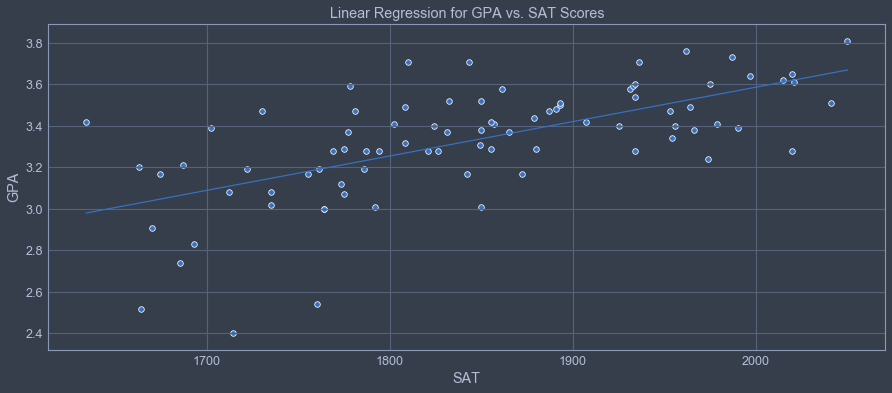

In [10]:
X_pred = np.linspace(np.min(dfGPA["SAT"]), np.max(dfGPA["SAT"]), 500) #create X values within range of domain
y_pred =  model.predict(pd.DataFrame(X_pred).rename({0:"SAT"}, axis=1)) #X values must be in DataFrame to use this predict function

plt.figure(figsize=(15, 6))
sns.scatterplot(dfGPA["SAT"], dfGPA["GPA"])
sns.lineplot(X_pred, y_pred)
plt.title("Linear Regression for GPA vs. SAT Scores")